In [25]:
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt


def plot_reaction_rates(fva_result, file_name):
    sns.set_context("notebook")

    _, ax1 = plt.subplots(figsize=(4.1, 3))
    ax1.plot(fva_result['ub'], fva_result['MAR09034'], label='Glucose uptake', linewidth=3, c="#BF1A2F")
    ax1.plot(fva_result['ub'], fva_result['MAR09135'], label='Lactate secretion', linewidth=3, c="#3066BE")
    ax1.set_ylabel('Reaction rate (mmol/gDW/h)')
    ax1.set_xlabel("O2 uptake boundary (mmol/gDW/h)")

    margin = 0.02
    ax1.margins(x=margin, y=margin)
    ax1.set_ylim(-margin, 4)
    plt.minorticks_on()

    ax2 = ax1.twinx()
    ax2.plot(fva_result['ub'], fva_result['MAR10024'], linewidth=3, label='Growth rate', c="#09BC8A")
    ax2.set_ylabel('Growth rate (1/h)')
    ax2.margins(x=margin, y=margin)
    ax2.grid(False)
    plt.minorticks_on()

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2)
    ax1.grid(False)

    file_path = Path("../../out/publication", file_name)
    plt.savefig(file_path, bbox_inches='tight', transparent=True, dpi=312)

    plt.show()


In [26]:
from cobra.io import read_sbml_model

original_model = read_sbml_model("../../model/ht29.xml")
original_model.solver = "gurobi"
original_model.tolerance = 1e-9


In [27]:
original_model.medium = {
    'MAR09034': 5.0,
    'MAR09035': 0.005,
    'MAR09036': 0.005,
    'MAR09038': 0.05,
    'MAR09039': 0.05,
    'MAR09040': 0.05,
    'MAR09041': 0.05,
    'MAR09042': 0.05,
    'MAR09043': 0.05,
    'MAR09044': 0.05,
    'MAR09045': 0.05,
    'MAR09046': 0.05,
    'MAR09048': 1000,
    'MAR09061': 0.05,
    'MAR09062': 0.05,
    'MAR09063': 0.5,
    'MAR09064': 0.05,
    'MAR09065': 0.05,
    'MAR09066': 0.05,
    'MAR09067': 0.05,
    'MAR09069': 0.05,
    'MAR09070': 0.05,
    'MAR09072': 1000.0,
    'MAR09076': 1000.0,
    'MAR09083': 0.005,
    'MAR09109': 0.005,
    'MAR09143': 0.005,
    'MAR09144': 0.005,
    'MAR09145': 0.005,
    'MAR09146': 0.005,
    'MAR09151': 0.005,
    'MAR09153': 0.005,
    'MAR09159': 0.005,
    'MAR09167': 0.005,
    'MAR09269': 0.005,
    'MAR09361': 0.005,
    'MAR09363': 0.05,
    'MAR09378': 0.005,
    'MAR09404': 0.005
}


In [28]:
# allow standard efflux of lactate
original_model.reactions.MAR05998.lower_bound = -1000.0

# prevent shuttle of lactate to mitochondria
original_model.reactions.MAR05411.bounds = 0, 0
original_model.reactions.MAR01485.bounds = 0, 0

original_model.reactions.MAR05027.bounds = 0, 0

# homo & THF
original_model.reactions.MAR11914.bounds = 0, 0
original_model.reactions.MAR09421.bounds = 0, 0

# preventing weird exports of lactate which only serve to reduce the overall flux
original_model.reactions.MAR06049.bounds = 0, 0
original_model.reactions.MAR01485.bounds = 0, 0
original_model.reactions.MAR06038.bounds = 0, 0
original_model.reactions.MAR06042.bounds = 0, 0
original_model.reactions.MAR06011.bounds = 0, 0
original_model.reactions.MAR06048.bounds = 0, 0
original_model.reactions.MAR06033.bounds = 0, 0
original_model.reactions.MAR06026.bounds = 0, 0
original_model.reactions.MAR06018.bounds = 0, 0
original_model.reactions.MAR06050.bounds = 0, 0
original_model.reactions.MAR06004.bounds = 0, 0

# HK analogs
original_model.reactions.MAR04486.bounds = 0, 0
original_model.reactions.MAR04487.bounds = 0, 0
original_model.reactions.MAR07747.bounds = 0, 0

# PK analogs
original_model.reactions.MAR04171.bounds = 0, 0
original_model.reactions.MAR04193.bounds = 0, 0
original_model.reactions.MAR04210.bounds = 0, 0
original_model.reactions.MAR04573.bounds = 0, 0
original_model.reactions.MAR06627.bounds = 0, 0
original_model.reactions.MAR04421.bounds = 0, 0

# weird bile acid biosynthesis reaction
# original_model.reactions.MAR01378.bounds = 0, 0  


## Fig. 2 Reference solutions for the cell type-specific model compared to the stoichiometrically reduced model.

In [29]:
import numpy as np
import pandas as pd
from cobra.flux_analysis import pfba

reaction_id = 'MAR09048'
reaction = original_model.reactions.get_by_id(reaction_id)

reaction.bounds = -1, 0
metabolite_name = next(iter(reaction.metabolites)).name

reactions = ['MAR10024', 'MAR09034', 'MAR09135']
points = 200
x = np.linspace(reaction.lower_bound, reaction.upper_bound,
                points, endpoint=True)

reaction_ids = [reaction.id] + reactions
result = pd.DataFrame(index=range(points), columns=reaction_ids)

with original_model as m:
    for i in range(points):
        reaction.bounds = x[i], -0
        solution = pfba(m)

        result.at[i, 'ub'] = abs(x[i])

        for reaction_id in reaction_ids:
            result.at[i, reaction_id] = abs(solution.fluxes[reaction_id])


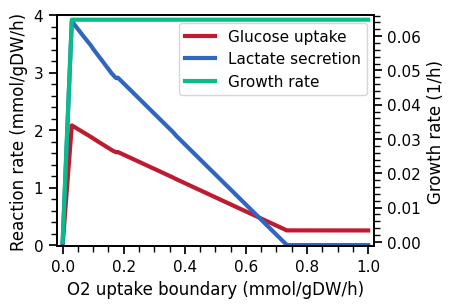

In [30]:
plot_reaction_rates(result, "full_pFBAvsO2UB.png")


In [31]:
import numpy as np
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis, pfba


def scan_flux_response(model, variable, constrained, dependent, points=200):
    """
    Sweep a reaction’s flux across its feasible range; at each step constrain another reaction to its minimal feasible flux (via FVA), run pFBA, and record the fluxes of specified reactions.
    """
    with model as m:
        variable_rxn = m.reactions.get_by_id(variable)
        x = np.linspace(variable_rxn.lower_bound, variable_rxn.upper_bound, points, endpoint=True)

        reaction_ids = [variable] + dependent
        result = pd.DataFrame(index=range(points))

        for i in range(points):
            variable_rxn.bounds = x[i], -0

            constrained_rxn = m.reactions.get_by_id(constrained)
            constrained_rxn.bounds = -5, 0
            constrained_rxn_fva = flux_variability_analysis(m, constrained, processes=1)

            min_constrained = constrained_rxn_fva.at[constrained, 'maximum']
            constrained_rxn.bounds = min_constrained, min_constrained

            try:
                solution = pfba(m)
                result.at[i, 'ub'] = abs(x[i])

                for reaction_id in reaction_ids:
                    result.at[i, reaction_id] = abs(solution.fluxes[reaction_id])
            except Exception as e:
                print(f"Error at point {i}: {e}")
                result.at[i, 'ub'] = 0
                for reaction_id in reaction_ids:
                    result.at[i, reaction_id] = 0

    return result


In [32]:
from cobra.io import read_sbml_model

reduced_model = read_sbml_model('../../model/ht29_pruned.xml')
reduced_model.solver = 'gurobi'

reduced_model.reactions.MAR09048.bounds = -1, 0
reduced_model_fluxes = scan_flux_response(reduced_model, 'MAR09048', 'MAR09034', reactions)


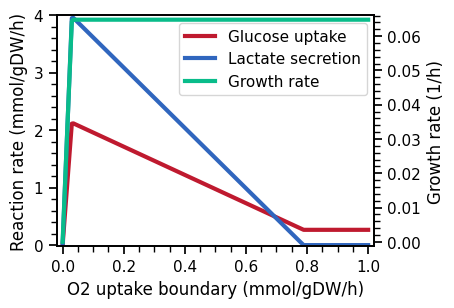

In [33]:
plot_reaction_rates(reduced_model_fluxes, "reduced_pFBAvsO2UB.png")
